In [15]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))

import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent import futures

from collaborative_filtering.item_based import ItemBased

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [2]:
DATA_DIR = os.path.join('..', 'data', 'processed', 'filtering')

In [3]:
with open(os.path.join(DATA_DIR, 'item_to_users.pickle'), 'rb') as file:
    item_to_users = pickle.load(file)

with open(os.path.join(DATA_DIR, 'train_ratings.pickle'), 'rb') as file:
    train_ratings = pickle.load(file)

with open(os.path.join(DATA_DIR, 'test_ratings.pickle'), 'rb') as file:
    test_ratings = pickle.load(file)

In [4]:
# get number of users and items
M = 1 + max(
    max([i[0] for i in train_ratings.keys()]),
    max([i[0] for i in test_ratings.keys()])
)
N = 1 + max(
    max([i[1] for i in train_ratings.keys()]),
    max([i[1] for i in test_ratings.keys()])
)
M, N

(9166, 1998)

### Fit model

In [21]:
MIN_NEIGHBORS = 10
MAX_NEIGHBORS = 240
MIN_COMMON_USERS = 5
STEP = 10
TRIALS = MAX_NEIGHBORS - MIN_NEIGHBORS + 1
N_WORKERS = 12

In [28]:
[(MIN_NEIGHBORS + i * TRIALS // N_WORKERS, MIN_NEIGHBORS +(i + 1) * TRIALS // N_WORKERS) for i in range(N_WORKERS)]

[(10, 29),
 (29, 48),
 (48, 67),
 (67, 87),
 (87, 106),
 (106, 125),
 (125, 144),
 (144, 164),
 (164, 183),
 (183, 202),
 (202, 221),
 (221, 241)]

In [29]:
def parallel_fit(min_neighbors, max_neighbors, step=STEP):
    train_scores, test_scores = [], []
    for neighbors in range(min_neighbors, max_neighbors, step):
        ibcf = ItemBased(M, N, neighbors=neighbors, min_common_users=MIN_COMMON_USERS)
        ibcf.fit(train_ratings, item_to_users)
        train_scores.append(ibcf.score(train_ratings))
        test_scores.append(ibcf.score(test_ratings))        
    return train_scores, test_scores

In [ ]:
pool = futures.ProcessPoolExecutor(N_WORKERS)

fs = [
    pool.submit(
        parallel_fit, 
        MIN_NEIGHBORS + i * TRIALS // N_WORKERS, 
        MIN_NEIGHBORS +(i + 1) * TRIALS // N_WORKERS
    ) 
    for i in range(N_WORKERS)
]
futures.wait(fs)
result = [f.result() for f in fs]

In [18]:
sns.set()

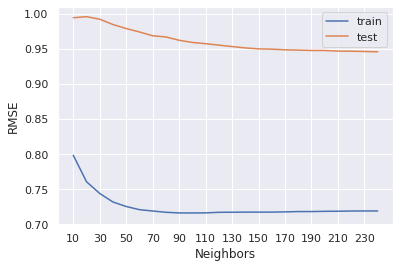

In [35]:
train_loss = np.concatenate([lst[0] for lst in result])
test_loss = np.concatenate([lst[1] for lst in result])
sns.lineplot(np.arange(MIN_NEIGHBORS, MAX_NEIGHBORS + 1, STEP), train_loss)
sns.lineplot(np.arange(MIN_NEIGHBORS, MAX_NEIGHBORS + 1, STEP), test_loss)
plt.xticks(np.arange(MIN_NEIGHBORS, MAX_NEIGHBORS + 1, STEP * 2))
plt.yticks(np.arange(0.7, 1, 0.05))
plt.legend(['train', 'test'])
plt.xlabel('Neighbors')
plt.ylabel('RMSE');
plt.savefig("ibcf.png")

In [14]:
test_loss

array([0.96010633, 0.99493391, 0.98400787, 0.97270937, 0.96608433,
       0.95802861, 0.95387174, 0.95053833, 0.94903104, 0.94817878,
       0.94728903, 0.94652907, 0.94631934, 0.94611066, 0.94543663,
       0.94516864, 0.94501943, 0.94487745, 0.94481995, 0.94473438,
       0.94471089, 0.94461591, 0.94449403, 0.94437315])